# Cross Correlation
In this notebook, we will have a look at the cross correlation and how it is useful in image processing. We will attempt to identify the location of a patch extracted from an image at random. This process is known as [template matching](https://en.wikipedia.org/wiki/Template_matching). This example is inspired from an [example of template matching from the ITK medical imaging library](https://itk.org/Wiki/ITK/Examples/Images/NormalizedCorrelationImageFilter). First define the usual helper functions, don't worry if you don't understand them fully.

In [2]:
import numpy as np

def padding_for_kernel(kernel):
    """ Return the amount of padding needed for each side of an image.

    For example, if the returned result is [1, 2], then this means an
    image should be padded with 1 extra row on top and bottom, and 2
    extra columns on the left and right.
    """
    # Slice to ignore RGB channels if they exist.
    image_shape = kernel.shape[:2]
    # We only handle kernels with odd dimensions so make sure that's true.
    # (The "center" pixel of an even number of pixels is arbitrary.)
    assert all((size % 2) == 1 for size in image_shape)
    return [(size - 1) // 2 for size in image_shape]

def add_padding(image, kernel):
    '''
    Add the appropriate padding (+ one extra) to an image given the kernel/template
    '''
    h_pad, w_pad = padding_for_kernel(kernel)
    return np.pad(image, ((h_pad, h_pad), (w_pad, w_pad)), 
                  mode='constant', constant_values=0)

def window_slice(center, kernel):
    '''
    Get the patch shape given the center and kernel/template size
    '''
    r, c = center
    r_pad, c_pad = padding_for_kernel(kernel)
    # Slicing is (inclusive, exclusive) so add 1 to the stop value
    return [slice(r-r_pad, r+r_pad+1), slice(c-c_pad, c+c_pad+1)]

def apply_kernel(center, kernel, original_image):
    '''
    Extract the patch at center and compute the (normalised) inner product
    '''
    #print(window_slice(center, kernel))
    image_patch = original_image[window_slice(center, kernel)]
    #print("Image Patch Shape:",image_patch.shape)
    #normalise the patch and template, very important!
    image_patch = image_patch / np.linalg.norm(image_patch)
    kernel = kernel / np.linalg.norm(kernel)
    # An element-wise multiplication followed by the sum
    return np.sum(kernel * image_patch)

Template matching is a common operation in computer vision (see also [OpenCV page](https://docs.opencv.org/2.4/doc/tutorials/imgproc/histograms/template_matching/template_matching.html)) and is done between an image and a template to match/find in the image:
![Template Matching](https://docs.opencv.org/2.4/_images/Template_Matching_Template_Theory_Summary.jpg)

Let's create/load an image and extract a template for matching, then apply the cross-correlations

In [3]:
from skimage import data
image = data.camera()
image = image.astype(np.float32) #ensure float values

n = 41
posX = 90
posY = 200
rangeX = posX+n
rangeY = posY+n
actualCenter = (posX+n/2, posY+n/2)
print("Actual Center:", actualCenter)
template = image[posX:rangeX, posY:rangeY]

('Actual Center:', (110, 220))


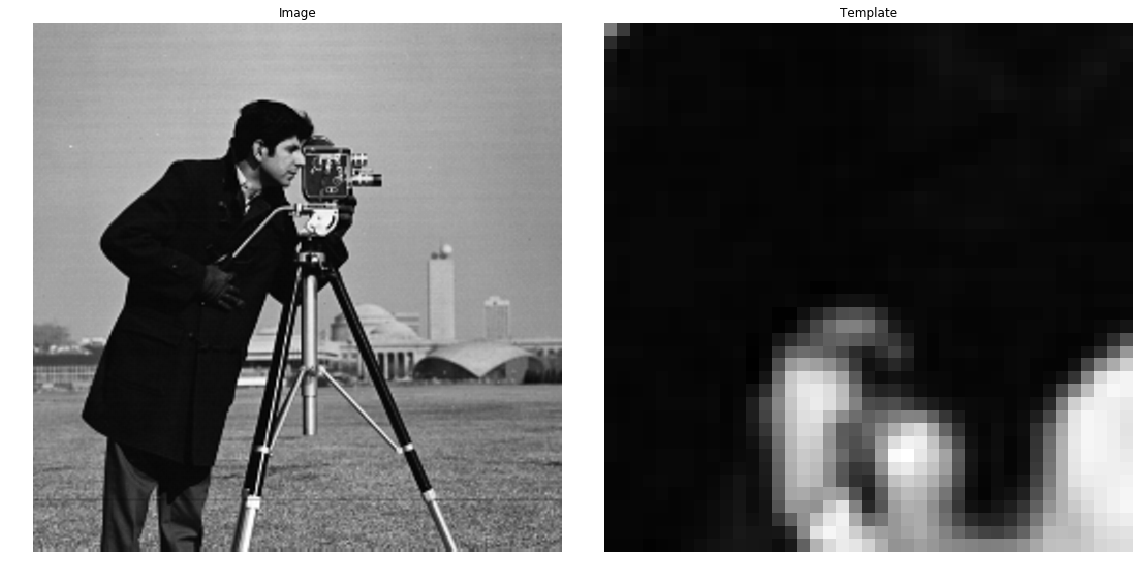

In [4]:
#plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

plt.gray()
plt.tight_layout()

ax[0].imshow(image, interpolation="nearest")
ax[0].axis('off')
ax[0].set_title('Image')
ax[1].imshow(template, interpolation="nearest")
ax[1].axis('off')
ax[1].set_title('Template')

plt.show()

Now we search for the template $T$ across all possible locations in the image $F$ using the normalised cross correlation (NCC) as $\left\langle\frac{F}{\|F\|},\frac{T}{\|T\|}\right\rangle$ and determine the location with the greatest correlation

In [5]:
#pad the image first
i_pad, j_pad = padding_for_kernel(template) #get how much padding will be applied
print("Padding:", (i_pad, j_pad))
paddedImage = add_padding(image, template) #apply the actual padding
print("Padded Image Shape:",paddedImage.shape)
#print(paddedImage)

filtered = np.zeros_like(paddedImage)
for xIndex, row in enumerate(image): #for every row
    for yIndex, column in enumerate(row): #for every column in row
        # Shift the center of the kernel to ignore padded border.
        i = xIndex + i_pad
        j = yIndex + j_pad
        center = (i, j)
        #print("center:", center)
        # Modify the pixel value at the kernel center by applying the kernel
        filtered[center] = apply_kernel(center, template, paddedImage)
        
print("Filtered Image:\n", filtered)

('Padding:', (20, 20))
('Padded Image Shape:', (552, 552))


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


('Filtered Image:\n', array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))


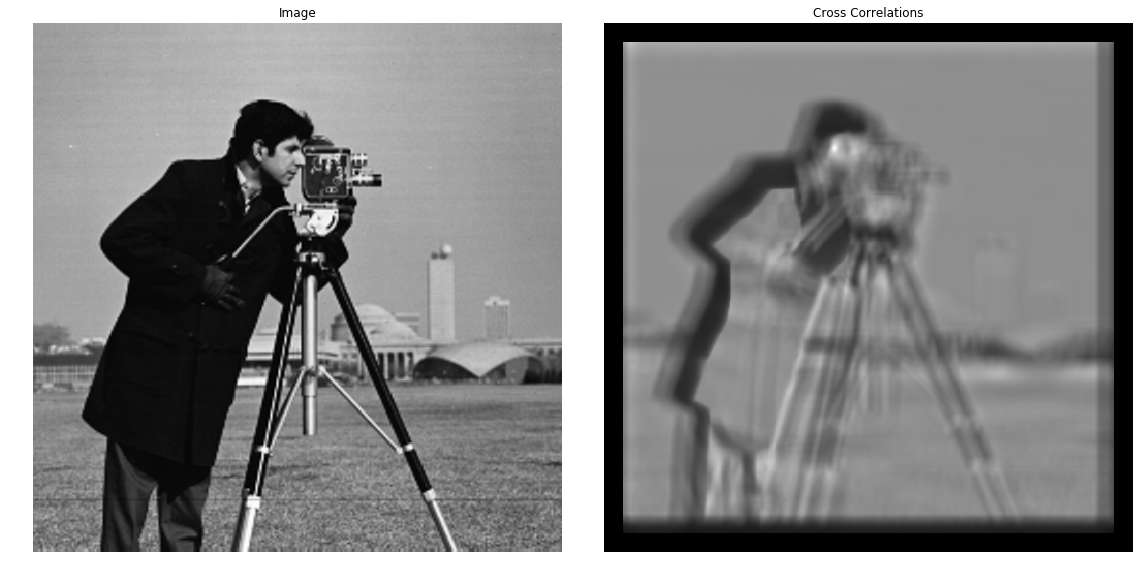

In [6]:
#plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

plt.gray()
plt.tight_layout()

ax[0].imshow(image, interpolation="nearest")
ax[0].axis('off')
ax[0].set_title('Image')
ax[1].imshow(filtered, interpolation="nearest")
ax[1].axis('off')
ax[1].set_title('Cross Correlations')

plt.show()

Let's identify the location as the maximum correlation value in the cross correlation image. It's the bright spot in the above image!

In [7]:
foundCenter = np.argmax(filtered) #finds the max value as if 2D array is 1D
foundCenter = np.unravel_index(foundCenter, filtered.shape) #convert 1D index to 2D
print("Found Center:", foundCenter)
print("Actual Center:", actualCenter)

('Found Center:', (130, 240))
('Actual Center:', (110, 220))


This forms the basis of normalised cross-correlation (NCC) based template matching. You can use it to find sub images in larger images. The NCC value can be used as a cost function for an optimisation process as well.